# Legal document classification in zero-shot cross lingual transfer setting

# Part I: Data acquisition and exploration

Date: May 2025

Project of course: Natural Language Processing - ENSAE 3A S2

Author: Noémie Guibé

In [1]:
import json
import pandas as pd

ModuleNotFoundError: No module named 'pandas'

# 1 - Load and reduce data

In [2]:
# import train, test and dev datasets - Note: this take 2-3 min
with open('../train.jsonl', 'r', encoding='utf-8') as f:
    train_ds = [json.loads(line) for line in f]
train_df = pd.DataFrame(train_ds).assign(split='train')
print(f'Train dataset has {len(train_df)} rows, as expected')

with open('../dev.jsonl', 'r', encoding='utf-8') as f:
    dev_ds = [json.loads(line) for line in f]
dev_df   = pd.DataFrame(dev_ds).assign(split='dev')
print(f'Dev dataset has {len(dev_df)} rows, as expected')

with open('../test.jsonl', 'r', encoding='utf-8') as f:
    test_ds = [json.loads(line) for line in f]
test_df  = pd.DataFrame(test_ds).assign(split='test')
print(f'Test dataset has {len(test_df)} rows, as expected')

df = pd.concat([train_df, dev_df, test_df], ignore_index=True)
df.head()

Train dataset has 55000 rows, as expected
Dev dataset has 5000 rows, as expected
Test dataset has 5000 rows, as expected


,celex_id,publication_date,text,eurovoc_concepts,split
0,32006D0213,2006-03-06,{'bg': '32006D0213 L 079/27 ОФИЦИАЛЕН ВЕСТНИК ...,"{'level_1': ['100160', '100155', '100158', '10...",train
1,32003R1330,2003-07-25,"{'bg': None, 'cs': None, 'da': 'Kommissionens ...","{'level_1': ['100148', '100157'], 'level_2': [...",train
2,32003R1786,2003-09-29,{'bg': '32003R1786 L 270/114 ОФИЦИАЛЕН ВЕСТНИК...,"{'level_1': ['100147', '100146', '100156'], 'l...",train
3,31985R2590,1985-09-13,"{'bg': None, 'cs': None, 'da': '***** KOMMISSI...","{'level_1': ['100150', '100157', '100146', '10...",train
4,31993R1103,1993-04-30,"{'bg': None, 'cs': None, 'da': 'KOMMISSIONENS ...","{'level_1': ['100161', '100147', '100152', '10...",train


## Data set reduction

Choosing one language per major language family (e.g., Germanic, Romance, Slavic, Uralic) preserves:

Syntactic and morphological variety (important for multilingual modeling)

A decent degree of label variability and document diversity

Faster processing due to smaller subsets

It gives you the ability to:

Still study multilingual behavior

Reduce computational cost

Retain enough complexity for meaningful insights

In [3]:
langs_to_keep = ['en', 'de', 'fr', 'pl', 'fi'] 
df_reduced = df.copy()
df_reduced['text'] = df['text'].apply(lambda x: {lang: x[lang] for lang in langs_to_keep if lang in x and x[lang] is not None})

# Memory reduction
original_memory = df.memory_usage(deep=True).sum() / (1024 ** 2)  # Convert to MB
reduced_memory = df_reduced.memory_usage(deep=True).sum() / (1024 ** 2)
memory_reduction_percentage = ((original_memory - reduced_memory) / original_memory) * 100
print(f"Number of empty rows: {len(df_reduced[df_reduced['text'].apply(lambda x: len(x))==0])}")
print(df_reduced.iloc[0]['text'])
print(f"Original memory usage: {original_memory:.2f} MB")
print(f"Reduced memory usage: {reduced_memory:.2f} MB")
print(f"Memory reduction: {memory_reduction_percentage:.2f}% lighter")

Number of empty rows: 0
{'en': 'COMMISSION DECISION\nof 6 March 2006\nestablishing the classes of reaction-to-fire performance for certain construction products as regards wood flooring and solid wood panelling and cladding\n(notified under document number C(2006) 655)\n(Text with EEA relevance)\n(2006/213/EC)\nTHE COMMISSION OF THE EUROPEAN COMMUNITIES,\nHaving regard to the Treaty establishing the European Community,\nHaving regard to Directive 89/106/EEC of 21 December 1988, on the approximation of laws, regulations and administrative provisions of the Member States relating to construction products (1), and in particular Article 20(2) thereof,\nWhereas:\n(1)\nDirective 89/106/EEC envisages that in order to take account of different levels of protection for construction works at national, regional or local level, it may be necessary to establish in the interpretative documents classes corresponding to the performance of products in respect of each essential requirement. Those docume

In [ ]:
# export
df_reduced.to_parquet('data/multi_eurlex_reduced.parquet', index=False)

# Law publication acrross years

c:\Users\guibe\anaconda3\envs\vscode\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


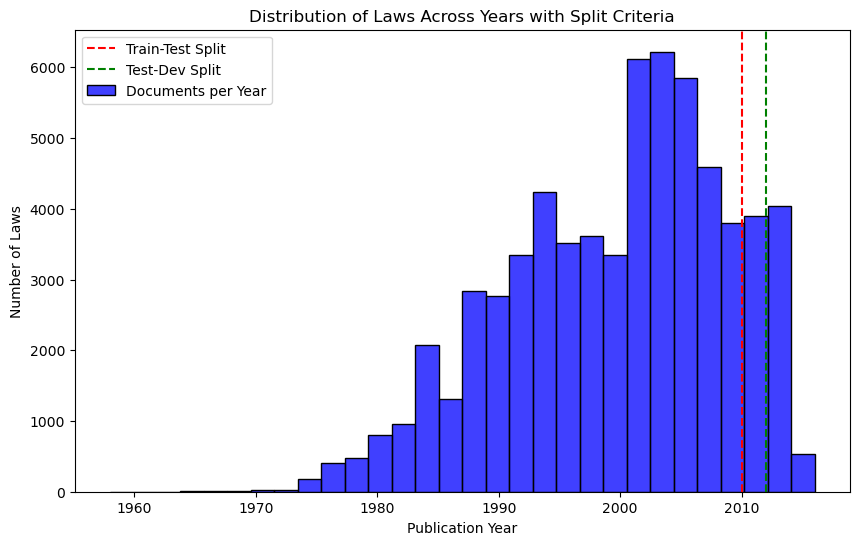

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert 'publication_date' to datetime
df_reduced['publication_date'] = pd.to_datetime(df_reduced['publication_date'])

# Extract publication year
df_reduced['publication_year'] = df_reduced['publication_date'].dt.year

# Plot the distribution of documents by year
plt.figure(figsize=(10,6))
sns.histplot(df_reduced['publication_year'], kde=False, bins=30, color='blue', label='Documents per Year')

# Add vertical lines for the split criteria
plt.axvline(x=2010, color='red', linestyle='--', label='Train-Test Split')
plt.axvline(x=2012, color='green', linestyle='--', label='Test-Dev Split')

# Adding labels and title
plt.title('Distribution of Laws Across Years with Split Criteria')
plt.xlabel('Publication Year')
plt.ylabel('Number of Laws')
plt.legend()

plt.show()


# Document Length

In [4]:
# Calculate the length of the document for each language
def compute_lengths(text_dict):
    lengths = {lang: len(text_dict[lang]) for lang in langs_to_keep if text_dict.get(lang) is not None}
    return lengths
# Apply the function to the 'text' column and store the result in a new column 'doc_lengths'
df_reduced['doc_lengths'] = df_reduced['text'].apply(compute_lengths)

In [33]:
df_reduced

,celex_id,publication_date,text,eurovoc_concepts,split,doc_lengths
0,32006D0213,2006-03-06,{'en': 'COMMISSION DECISION of 6 March 2006 es...,"{'level_1': ['100160', '100155', '100158', '10...",train,"{'en': 3233, 'de': 3302, 'fr': 3642, 'pl': 332..."
1,32003R1330,2003-07-25,{'en': 'Commission Regulation (EC) No 1330/200...,"{'level_1': ['100148', '100157'], 'level_2': [...",train,"{'en': 1328, 'de': 1430, 'fr': 1437, 'fi': 1366}"
2,32003R1786,2003-09-29,{'en': 'Council Regulation (EC) No 1786/2003 o...,"{'level_1': ['100147', '100146', '100156'], 'l...",train,"{'en': 17741, 'de': 19641, 'fr': 19133, 'pl': ..."
3,31985R2590,1985-09-13,{'en': '***** COMMISSION REGULATION (EEC) No 2...,"{'level_1': ['100150', '100157', '100146', '10...",train,"{'en': 2525, 'de': 2720, 'fr': 2684, 'fi': 2527}"
4,31993R1103,1993-04-30,{'en': 'COMMISSION REGULATION (EEC) No 1103/93...,"{'level_1': ['100161', '100147', '100152', '10...",train,"{'en': 27992, 'de': 29436, 'fr': 32297}"
...,...,...,...,...,...,...
64995,32014R1325,2014-12-10,{'en': 'COMMISSION REGULATION (EU) No 1325/201...,"{'level_1': ['100145', '100155', '100154', '10...",test,"{'en': 1828, 'de': 2007, 'fr': 1995, 'pl': 200..."
64996,32015R0122,2015-01-22,{'en': 'COMMISSION REGULATION (EU) 2015/122 of...,"{'level_1': ['100145', '100154', '100161', '10...",test,"{'en': 1890, 'de': 2115, 'fr': 2116, 'pl': 208..."
64997,32014R0860,2014-08-05,{'en': 'COMMISSION IMPLEMENTING REGULATION (EU...,"{'level_1': ['100147', '100160'], 'level_2': [...",test,"{'en': 2522, 'de': 2647, 'fr': 2802, 'pl': 261..."
64998,32013D0392,2013-07-22,{'en': 'COUNCIL DECISION of 22 July 2013 fixin...,"{'level_1': ['100150', '100145'], 'level_2': [...",test,"{'en': 5104, 'de': 5381, 'fr': 5420, 'pl': 477..."


In [5]:
# Now, let's compute the statistics for document lengths
all_lengths = []

# Collect lengths from the 'doc_lengths' dictionary
for row in df_reduced['doc_lengths']:
    all_lengths.extend(row.values())  # Add all language lengths for this row to the list

# Overall statistics across all languages
overall_stats = pd.Series(all_lengths).describe()

print("Overall Document Length Statistics (across all languages):")
print(overall_stats)

Overall Document Length Statistics (across all languages):
count    2.806940e+05
mean     8.072066e+03
std      2.102396e+04
min      5.380000e+02
25%      2.047000e+03
50%      2.951000e+03
75%      5.859000e+03
max      1.440461e+06
dtype: float64


That max value is very high — possibly an outlier or a preprocessing issue (e.g., law with annexes). Might be worth inspecting or truncating for modeling.

The mean > median suggests a right-skewed distribution — common in legal corpora where a few laws are much longer than the rest.

c:\Users\guibe\anaconda3\envs\vscode\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


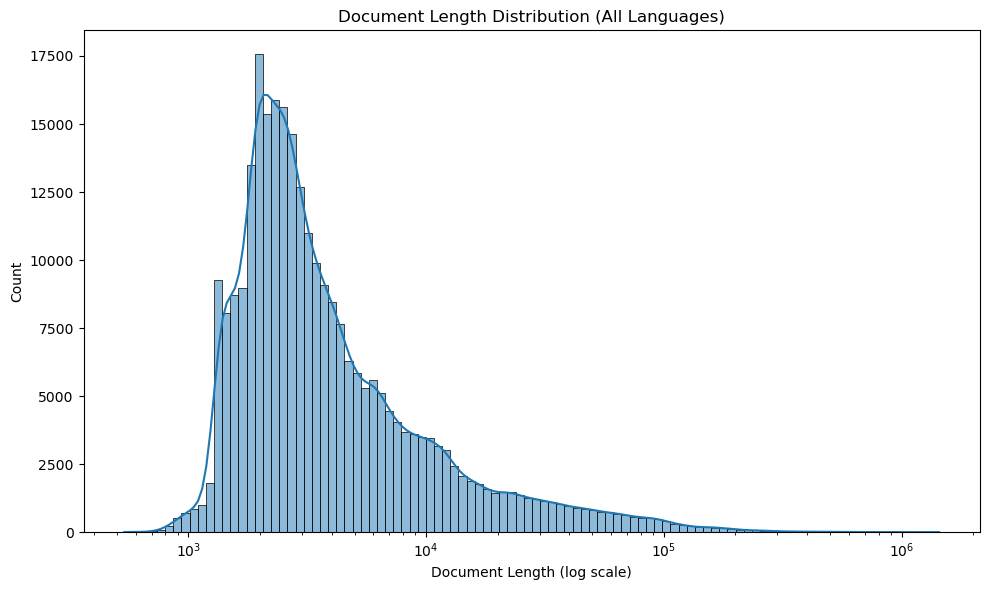

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create a DataFrame from all_lengths
all_lengths_df = pd.DataFrame({'doc_length': all_lengths})

# Plot histogram with log-scaled x-axis
plt.figure(figsize=(10, 6))
sns.histplot(all_lengths_df['doc_length'], bins=100, log_scale=(True, False), kde=True)
plt.title('Document Length Distribution (All Languages)')
plt.xlabel('Document Length (log scale)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


In [35]:
# Now, let's calculate document length statistics per language
lengths_per_language = {lang: [] for lang in langs_to_keep}

for row in df_reduced['doc_lengths']:
    for lang, length in row.items():
        lengths_per_language[lang].append(length)

# Now, compute statistics for each language
language_stats = {}
for lang, lengths in lengths_per_language.items():
    language_stats[lang] = pd.Series(lengths).describe()

print("\nDocument Length Statistics Per Language:")
for lang, stats in language_stats.items():
    print(f"\nStatistics for {lang}:")
    print(stats)


Document Length Statistics Per Language:

Statistics for en:
count    6.500000e+04
mean     7.477300e+03
std      1.913348e+04
min      5.660000e+02
25%      1.981000e+03
50%      2.835000e+03
75%      5.549250e+03
max      1.269363e+06
dtype: float64

Statistics for de:
count    6.500000e+04
mean     8.081598e+03
std      2.113035e+04
min      5.920000e+02
25%      2.108000e+03
50%      2.992000e+03
75%      5.914000e+03
max      1.361562e+06
dtype: float64

Statistics for fr:
count    6.500000e+04
mean     8.234370e+03
std      2.143805e+04
min      5.510000e+02
25%      2.129000e+03
50%      3.063000e+03
75%      6.058000e+03
max      1.440461e+06
dtype: float64

Statistics for pl:
count    3.319700e+04
mean     8.919184e+03
std      2.324453e+04
min      5.380000e+02
25%      2.032000e+03
50%      3.031000e+03
75%      6.362000e+03
max      1.381409e+06
dtype: float64

Statistics for fi:
count    5.249700e+04
mean     8.060043e+03
std      2.110993e+04
min      5.550000e+02
25%   

c:\Users\guibe\anaconda3\envs\vscode\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\guibe\anaconda3\envs\vscode\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\guibe\anaconda3\envs\vscode\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\guibe\anaconda3\envs\vscode\Lib\site-packages\seaborn\_oldcore.

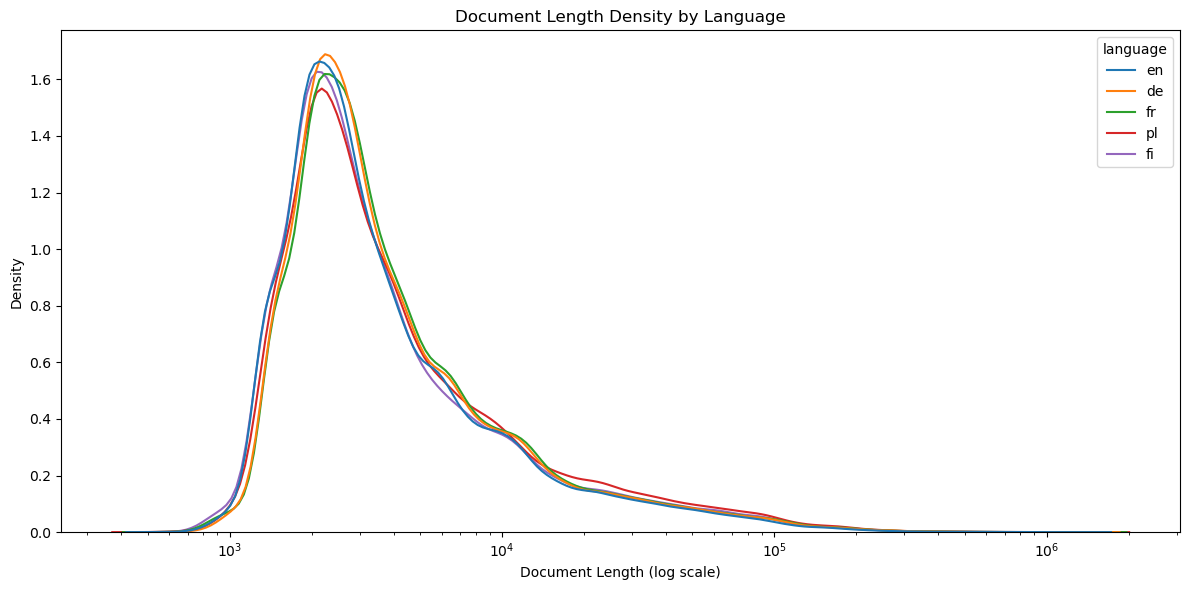

In [40]:
records = []
for lang, lengths in lengths_per_language.items():
    records.extend([{'length': l, 'language': lang} for l in lengths])

df_langs_only = pd.DataFrame(records)

# Plot per-language KDE curves
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df_langs_only, x='length', hue='language', common_norm=False, log_scale=True, fill=False)

plt.title('Document Length Density by Language')
plt.xlabel('Document Length (log scale)')
plt.ylabel('Density')
plt.tight_layout()
plt.show()


In [41]:
# First, find the max length and which row it's in
max_length = max(all_lengths)

# Find the row index in df_reduced['doc_lengths'] where this occurs
outlier_idx = df_reduced['doc_lengths'].apply(lambda d: max(d.values(), default=0)).idxmax()

# Now get the full row
outlier_row = df_reduced.loc[outlier_idx]

# Display info
print(f"Outlier index: {outlier_idx}")
print(f"Document lengths per language: {outlier_row['doc_lengths']}")

# If you want to see the text (be careful — it's long!)
for lang, text in outlier_row['text'].items():
    print(f"\nLanguage: {lang}\nLength: {len(text)}\n--- Sample Start ---\n{text[:1000]}...\n")

Outlier index: 60074
Document lengths per language: {'en': 1269363, 'de': 1361562, 'fr': 1440461, 'pl': 1381409, 'fi': 1330363}

Language: en
Length: 1269363
--- Sample Start ---
REGULATION (EU) No 575/2013 OF THE EUROPEAN PARLIAMENT AND OF THE COUNCIL
of 26 June 2013
on prudential requirements for credit institutions and investment firms and amending Regulation (EU) No 648/2012
(Text with EEA relevance)
THE EUROPEAN PARLIAMENT AND THE COUNCIL OF THE EUROPEAN UNION,
Having regard to the Treaty on the Functioning of the European Union, and in particular Article 114 thereof,
Having regard to the proposal from the European Commission,
After transmission of the draft legislative act to the national parliaments,
Having regard to the opinion of the European Central Bank (1),
Having regard to the opinion of the European Economic and Social Committee (2),
Acting in accordance with the ordinary legislative procedure,
Whereas:
(1)
The G-20 Declaration of 2 April 2009 on Strengthening of the Fina

In [7]:
# Compute max length per row (if not done already)
df_reduced['max_doc_length'] = df_reduced['doc_lengths'].apply(lambda d: max(d.values(), default=0))

# Get top 10 longest documents
top_10 = df_reduced['max_doc_length'].nlargest(10)

# Create a DataFrame with their index, length, and other identifying info
top_10_df = df_reduced.loc[top_10.index].copy()
top_10_df['doc_length'] = top_10.values
top_10_df['index'] = top_10.index

# If your DataFrame has a column indicating split (e.g. 'split'), include it:
# If not, you can manually assign it based on how you split the data originally

# Display the info
print(top_10_df[['index', 'doc_length', 'split','publication_date']])


       index  doc_length  split publication_date
60074  60074     1440461   test       2013-06-26
15924  15924      926327  train       1993-07-02
63656  63656      743757   test       2013-12-02
6280    6280      703788  train       2002-04-17
64587  64587      609582   test       2014-05-15
53825  53825      587757  train       2001-10-10
40371  40371      565908  train       1994-11-30
42935  42935      564883  train       2009-11-25
10358  10358      563527  train       1999-09-29
63388  63388      520690   test       2014-05-15


6 out of the top 10 longest documents are in train,

4 are in test,

0 are in dev — likely due to the smaller size or sampling strategy.

So your train set is definitely absorbing most of the heavy documents, which is actually ideal for model training — but also a reminder that your model may need to handle very long sequences unless you truncate.

Older documents (e.g., from 1993-2002) are prevalent, which could suggest that there might be specific types of legislation (or areas) that tend to be longer.

Documents from 2013-2014 seem more recent, which could represent later regulations or newer legislation.

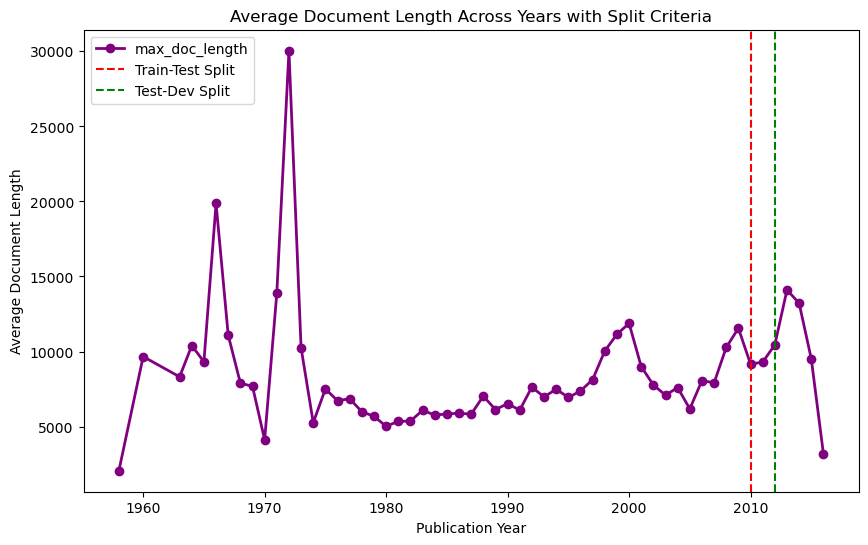

In [ ]:
# Group by publication year and calculate the average document length per year
df_reduced['max_doc_length'] = df_reduced['doc_lengths'].apply(lambda d: max(d.values(), default=0))  # Ensure max doc length is available
avg_doc_length_per_year = df_reduced.groupby('publication_year')['max_doc_length'].mean()

# Plot the average document length per year
plt.figure(figsize=(10,6))
avg_doc_length_per_year.plot(kind='line', color='purple', marker='o', linestyle='-', linewidth=2)

# Add vertical lines for the split criteria
plt.axvline(x=2010, color='red', linestyle='--', label='Train-Test Split')
plt.axvline(x=2012, color='green', linestyle='--', label='Test-Dev Split')

# Adding labels and title
plt.title('Average Document Length Across Years with Split Criteria')
plt.xlabel('Publication Year')
plt.ylabel('Average Document Length')
plt.legend()

plt.show()

In [59]:
# Calculate the average document length for each law across languages from 'doc_lengths'
def avg_doc_length(doc_lengths):
    # Check if doc_lengths is None or empty
    if doc_lengths is None or len(doc_lengths) == 0:
        return 0  # Return 0 for missing or empty documents
    # Calculate the average length across all languages
    return sum(doc_lengths.values()) / len(doc_lengths)

# Apply the function to the 'doc_lengths' column and store the result in 'avg_doc_length'
df_reduced['avg_doc_length'] = df_reduced['doc_lengths'].apply(avg_doc_length)

# Check the result
print(df_reduced[['celex_id', 'avg_doc_length', 'publication_date']].head())


     celex_id  avg_doc_length publication_date
0  32006D0213     3315.200000       2006-03-06
1  32003R1330     1390.250000       2003-07-25
2  32003R1786    18677.200000       2003-09-29
3  31985R2590     2614.000000       1985-09-13
4  31993R1103    29908.333333       1993-04-30


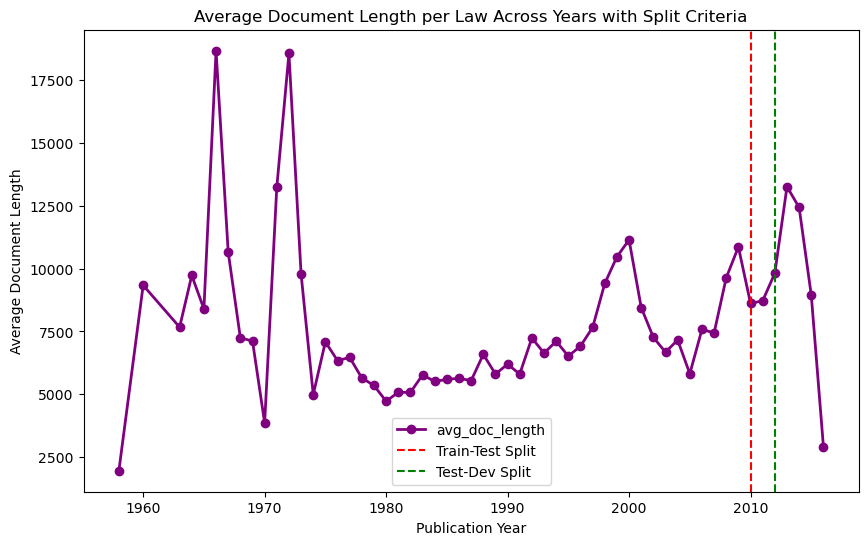

In [60]:
# Extract publication year from the 'publication_date' column
df_reduced['publication_year'] = pd.to_datetime(df_reduced['publication_date']).dt.year

# Group by publication year and calculate the average document length per year
avg_doc_length_per_year = df_reduced.groupby('publication_year')['avg_doc_length'].mean()

# Plot the average document length per year
plt.figure(figsize=(10,6))
avg_doc_length_per_year.plot(kind='line', color='purple', marker='o', linestyle='-', linewidth=2)

# Add vertical lines for the split criteria
plt.axvline(x=2010, color='red', linestyle='--', label='Train-Test Split')
plt.axvline(x=2012, color='green', linestyle='--', label='Test-Dev Split')

# Adding labels and title
plt.title('Average Document Length per Law Across Years with Split Criteria')
plt.xlabel('Publication Year')
plt.ylabel('Average Document Length')
plt.legend()

plt.show()


In [10]:
# drop documents longer than 500k 
df_reduced = df_reduced[df_reduced['max_doc_length']<500000]

In [12]:
df_reduced.to_csv('data/multi_eurlex_reduced.csv', index=False)

In [11]:
df_reduced.to_parquet('data/multi_eurlex_reduced.parquet', index=False)

MemoryError: 

# Language distribution

In [91]:
# number of laws without all langua&ges translations
len(df_reduced[df_reduced['text'].apply(lambda x: len(x))<4])

12248

In [93]:
# Step 1: Language Distribution Across All Documents
# Flatten the 'text' dictionary for all rows and get the count of documents per language
language_counts_all = df_reduced['text'].apply(lambda x: list(x.keys()) if x is not None else []).explode().value_counts()

# Calculate the total number of documents
total_docs = df_reduced.shape[0]

# Calculate the proportion of each language across all documents
language_proportion_all = language_counts_all / total_docs

# Display the proportions
print('Language Proportion Across All Documents:')
print(language_proportion_all)

# Step 2: Language Distribution for Each Split (train, test, dev)
def language_distribution_by_split(split_name):
    # Filter the DataFrame by split
    df_split = df_reduced[df_reduced['split'] == split_name]
    
    # Get the language counts in the 'text' column for this split
    split_language_counts = df_split['text'].apply(lambda x: list(x.keys()) if x is not None else []).explode().value_counts()
    
    # Calculate the total number of documents in the split
    total_docs_split = df_split.shape[0]
    
    # Calculate the proportion of each language in this split
    split_language_proportion = split_language_counts / total_docs_split
    
    return split_language_proportion

# Get language distribution for each split
train_language_proportion = language_distribution_by_split('train')
test_language_proportion = language_distribution_by_split('test')
dev_language_proportion = language_distribution_by_split('dev')

# Display the results
print('\nLanguage Proportion for Train Split:')
print(train_language_proportion)

print('\nLanguage Proportion for Test Split:')
print(test_language_proportion)

print('\nLanguage Proportion for Dev Split:')
print(dev_language_proportion)


Language Proportion Across All Documents:
text
en    1.000000
de    1.000000
fr    1.000000
fi    0.807646
pl    0.510723
Name: count, dtype: float64

Language Proportion for Train Split:
text
en    1.000000
de    1.000000
fr    1.000000
fi    0.772673
pl    0.421764
Name: count, dtype: float64

Language Proportion for Test Split:
text
en    1.0
de    1.0
fr    1.0
pl    1.0
fi    1.0
Name: count, dtype: float64

Language Proportion for Dev Split:
text
en    1.0
de    1.0
fr    1.0
pl    1.0
fi    1.0
Name: count, dtype: float64


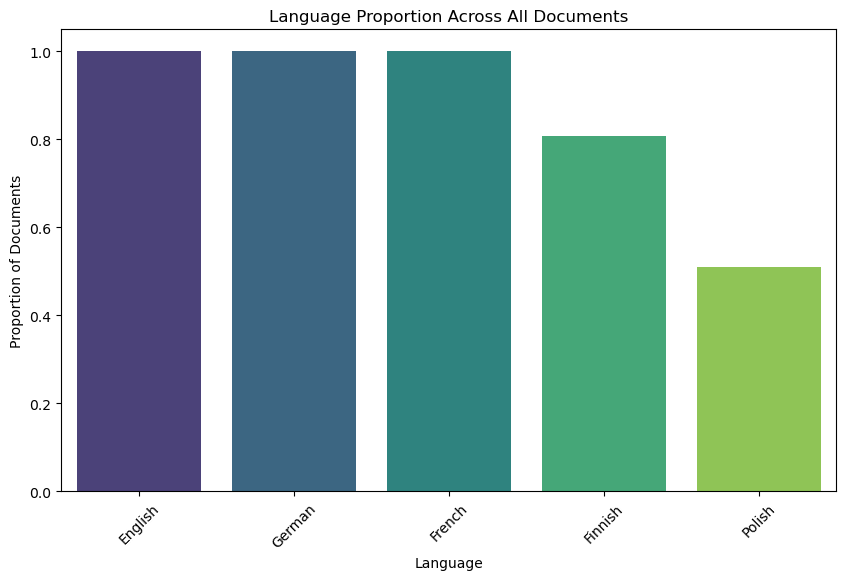

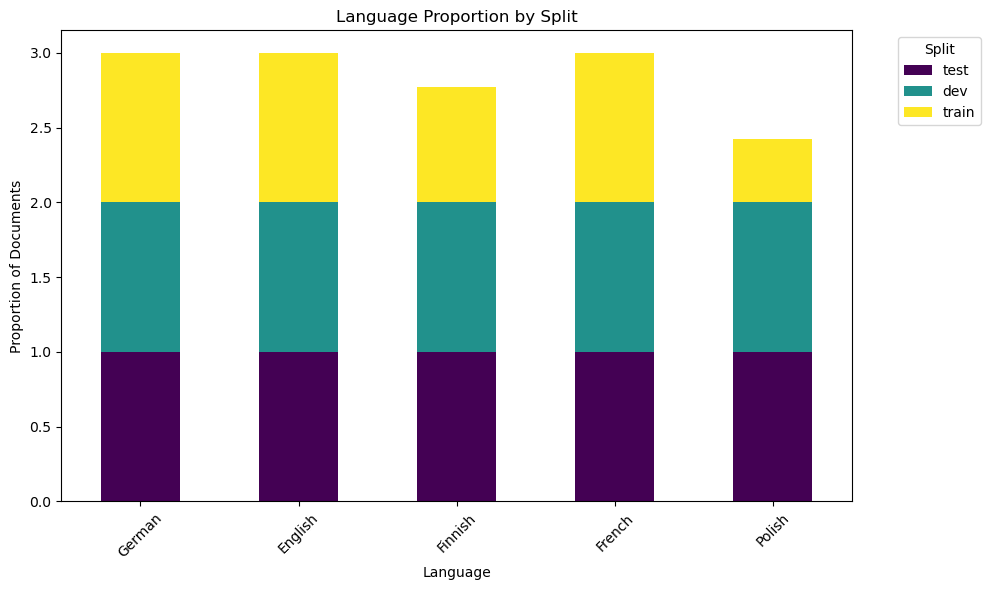

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns

language_full_names = {
    'en': 'English',
    'de': 'German',
    'fr': 'French',
    'pl': 'Polish',
    'fi': 'Finnish'
}


# Step 1: Plot the Language Proportion Across All Documents
plt.figure(figsize=(10, 6))
sns.barplot(x=language_proportion_all.index, y=language_proportion_all.values, palette="viridis")
plt.title('Language Proportion Across All Documents')
plt.xlabel('Language')
plt.xticks(ticks=range(len(language_proportion_all.index)), labels=[language_full_names[lang] for lang in language_proportion_all.index], rotation=45)
plt.ylabel('Proportion of Documents')
plt.show()

# Step 2: Plot Stacked Bar Chart for Language Proportion by Split
# We want to stack the proportions for each split
split_language_proportions = pd.DataFrame({
    'test': test_language_proportion,
    'dev': dev_language_proportion,
    'train': train_language_proportion
}).fillna(0)  # Fill missing values with 0 if a language is missing in a split

# Plotting stacked bar chart
split_language_proportions.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title('Language Proportion by Split')
plt.xlabel('Language')
plt.xticks(ticks=range(len(split_language_proportions.index)), labels=[language_full_names[lang] for lang in split_language_proportions.index], rotation=45)
plt.ylabel('Proportion of Documents')
plt.xticks(rotation=45)
plt.legend(title='Split', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()  # To ensure that labels and legend fit
plt.show()


All laws are translate in english, french and german so this is normal. Laws in the train and dev splits are also all translated for the languages we consider. (c.f. Table 1 in the article)

Only µa bit more than half of train documents are translated in polish

# Label distribution

In [6]:
keys_to_keep = ['text', 'labels']

with open("data/eurovoc_descriptors.json", "r", encoding="utf-8") as f:
    labels = json.load(f)

english_only = {k: v.get("en") for k, v in labels.items() if v.get("en") is not None}
labels = pd.DataFrame(list(english_only.items()), columns=["label_id", "label_description"])

with open("data/eurovoc_concepts.json", "r", encoding="utf-8") as f:
    levels = json.load(f)
level_data = [
    {"label_id": label_id, "level": level}
    for level, label_ids in levels.items()
    for label_id in label_ids
]
df_levels = pd.DataFrame(level_data)
df_labels = pd.merge(labels, df_levels, on='label_id', how='inner')
df_labels =df_labels[df_labels['level']!='original']
print(f"Size of label level: \n {df_labels['level'].value_counts()}")

Size of label level: 
 level
level_4    3861
level_5    2284
level_3     567
level_6     481
level_2     127
level_7      43
level_1      21
level_8       6
Name: count, dtype: int64


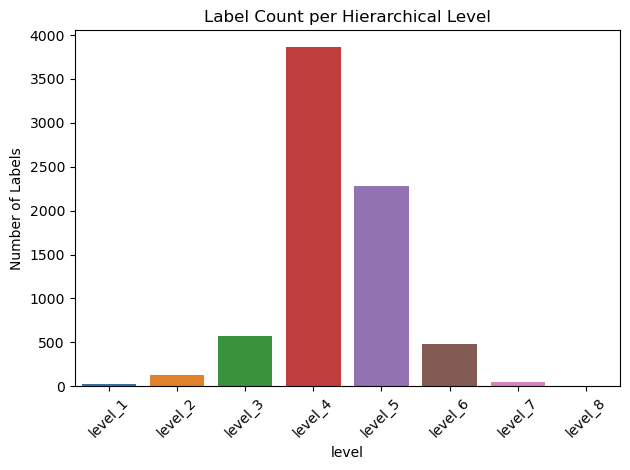

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count labels per level
level_counts = df_labels['level'].value_counts().sort_index()

# Barplot
sns.barplot(x=level_counts.index, y=level_counts.values)
plt.xticks(rotation=45)
plt.ylabel("Number of Labels")
plt.title("Label Count per Hierarchical Level")
plt.tight_layout()
plt.show()


In [7]:
df_labels[df_labels['level']=='level_1']

,label_id,label_description,level
0,100149,social questions,level_1
2,100160,industry,level_1
4,100148,finance,level_1
6,100147,trade,level_1
8,100152,business and competition,level_1
10,100143,international relations,level_1
12,100156,"agriculture, forestry and fisheries",level_1
14,100158,"production, technology and research",level_1
16,100154,transport,level_1
18,100153,employment and working conditions,level_1


In [128]:
from collections import defaultdict
import pandas as pd

# Initialize
label_freq = defaultdict(int)
label_by_level = defaultdict(list)

# Iterate over your dataset
for concepts in df_reduced['eurovoc_concepts']:
    for level, labels in concepts.items():
        if level != 'original':
            for label in labels:
                label_freq[label] += 1
                label_by_level[level].append(label)

# Optional: convert to DataFrame for easier analysis
df_label_freq = pd.DataFrame([
    {"label_id": label, "count": count}
    for label, count in label_freq.items()
])


In [ ]:
df_label_stats = df_label_freq.merge(df_labels, on="label_id", how="left")

In [132]:
df_label_stats.groupby("level")["count"].describe()

,count,mean,std,min,25%,50%,75%,max
level,,,,,,,,
level_1,21.0,10191.476190,10358.475977,712.0,3335.0,5904.0,10988.0,35681.0
level_2,127.0,2331.614173,3669.759557,5.0,318.0,915.0,2165.5,20812.0
level_3,512.0,799.908203,1787.242072,1.0,56.0,195.5,664.5,15554.0
level_4,2504.0,83.527955,285.700123,1.0,3.0,10.0,45.0,5282.0
level_5,1347.0,57.172235,224.360720,1.0,3.0,9.0,35.0,4612.0
level_6,281.0,56.722420,182.216809,1.0,3.0,9.0,35.0,2360.0
level_7,25.0,36.280000,85.320240,1.0,2.0,5.0,21.0,338.0
level_8,5.0,3.600000,1.949359,1.0,3.0,3.0,5.0,6.0


c:\Users\guibe\anaconda3\envs\vscode\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


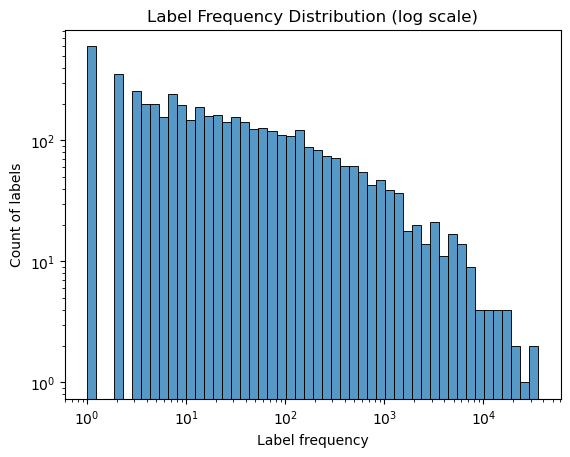

In [133]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df_label_stats["count"], bins=50, log_scale=(True, True))
plt.title("Label Frequency Distribution (log scale)")
plt.xlabel("Label frequency")
plt.ylabel("Count of labels")
plt.show()


In [134]:
def get_label_counts_per_split(df, split_name):
    split_df = df[df["split"] == split_name]
    label_freq_split = defaultdict(int)
    
    for concepts in split_df["eurovoc_concepts"]:
        for level, labels in concepts.items():
            if level != "original":
                for label in labels:
                    label_freq_split[label] += 1

    return pd.DataFrame([
        {"label_id": k, "count": v} for k, v in label_freq_split.items()
    ])

train_freq = get_label_counts_per_split(df_reduced, "train")
dev_freq = get_label_counts_per_split(df_reduced, "dev")
test_freq = get_label_counts_per_split(df_reduced, "test")
